# Importing The Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from sklearn.decomposition import PCA, TruncatedSVD, NMF, KernelPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

# Loading + Preprocessing The Image

In [3]:
astronaut = data.astronaut()
print(f"Original image shape: {astronaut.shape}")
print(f"Original image data type: {astronaut.dtype}")

Original image shape: (512, 512, 3)
Original image data type: uint8


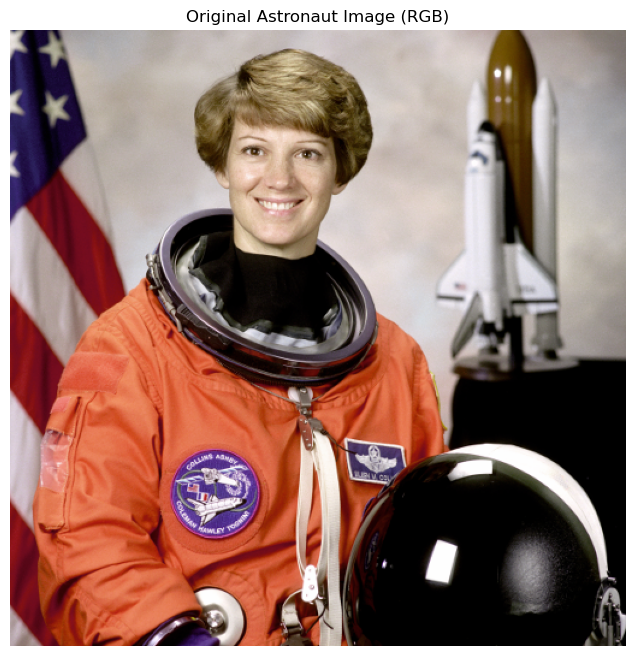

In [4]:
plt.figure(figsize=(8, 8))
plt.imshow(astronaut)
plt.title('Original Astronaut Image (RGB)')
plt.axis('off')
plt.show()

In [5]:
astronaut_gray = color.rgb2gray(astronaut)
print(f"Grayscale image shape: {astronaut_gray.shape}")
print(f"Grayscale image range: [{astronaut_gray.min():.4f}, {astronaut_gray.max():.4f}]")

Grayscale image shape: (512, 512)
Grayscale image range: [0.0000, 1.0000]


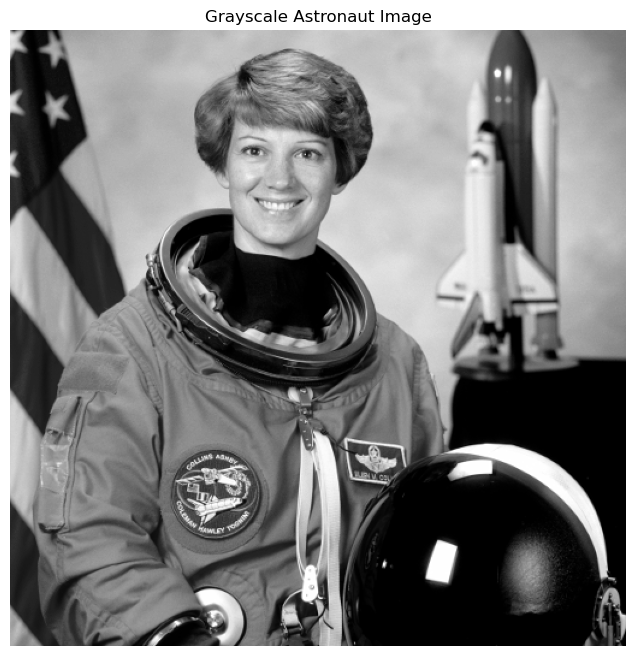

In [6]:
plt.figure(figsize=(8, 8))
plt.imshow(astronaut_gray, cmap='gray')
plt.title('Grayscale Astronaut Image')
plt.axis('off')
plt.show()

In [7]:
astronaut_flat = astronaut_gray.flatten().reshape(-1, 1)
scaler = MinMaxScaler()
astronaut_normalized = scaler.fit_transform(astronaut_flat)
astronaut_normalized_2d = astronaut_normalized.reshape(astronaut_gray.shape)

print(f"Normalized image range: [{astronaut_normalized.min():.4f}, {astronaut_normalized.max():.4f}]")

Normalized image range: [0.0000, 1.0000]


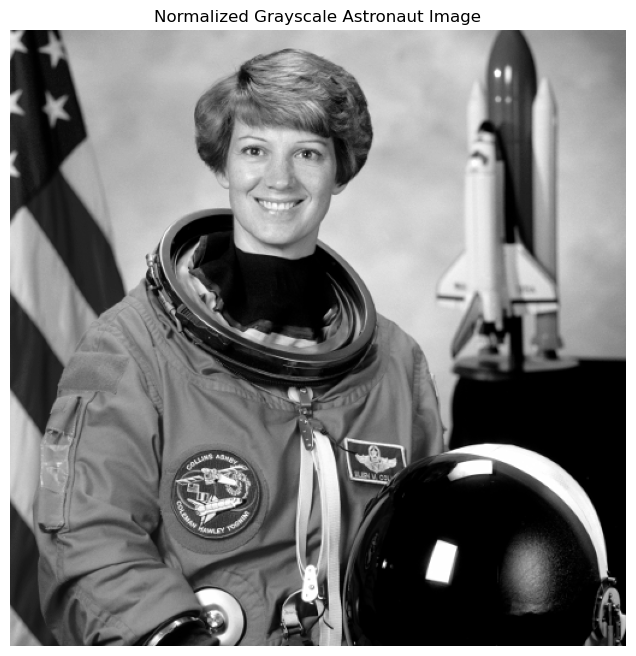

In [8]:
plt.figure(figsize=(8, 8))
plt.imshow(astronaut_normalized_2d, cmap='gray')
plt.title('Normalized Grayscale Astronaut Image')
plt.axis('off')
plt.show()

In [9]:
n_samples, n_features = astronaut_gray.shape
X = astronaut_normalized_2d

print(f"Image dimensions: {n_samples} x {n_features}")
print(f"Data matrix shape: {X.shape}")

Image dimensions: 512 x 512
Data matrix shape: (512, 512)


# Defining Prerequisites of DR Methods

In [10]:
k_values = [5, 20, 50, 100]

reconstructed_images = {
    'PCA': {},
    'Truncated SVD': {},
    'Kernel PCA (RBF)': {},
    'NMF': {}
}

mse_values = {
    'PCA': [],
    'Truncated SVD': [],
    'Kernel PCA (RBF)': [],
    'NMF': []
}

# Implementing PCA

In [11]:
for k in k_values:
    pca = PCA(n_components=k, random_state=42)
    
    X_pca = pca.fit_transform(X)
    
    X_reconstructed = pca.inverse_transform(X_pca)
    
    reconstructed_images['PCA'][k] = X_reconstructed
    
    mse = mean_squared_error(X, X_reconstructed)
    mse_values['PCA'].append(mse)
    
    print(f"  k={k}: MSE = {mse:.6f}")

  k=5: MSE = 0.021831
  k=20: MSE = 0.005913
  k=50: MSE = 0.001805
  k=100: MSE = 0.000509


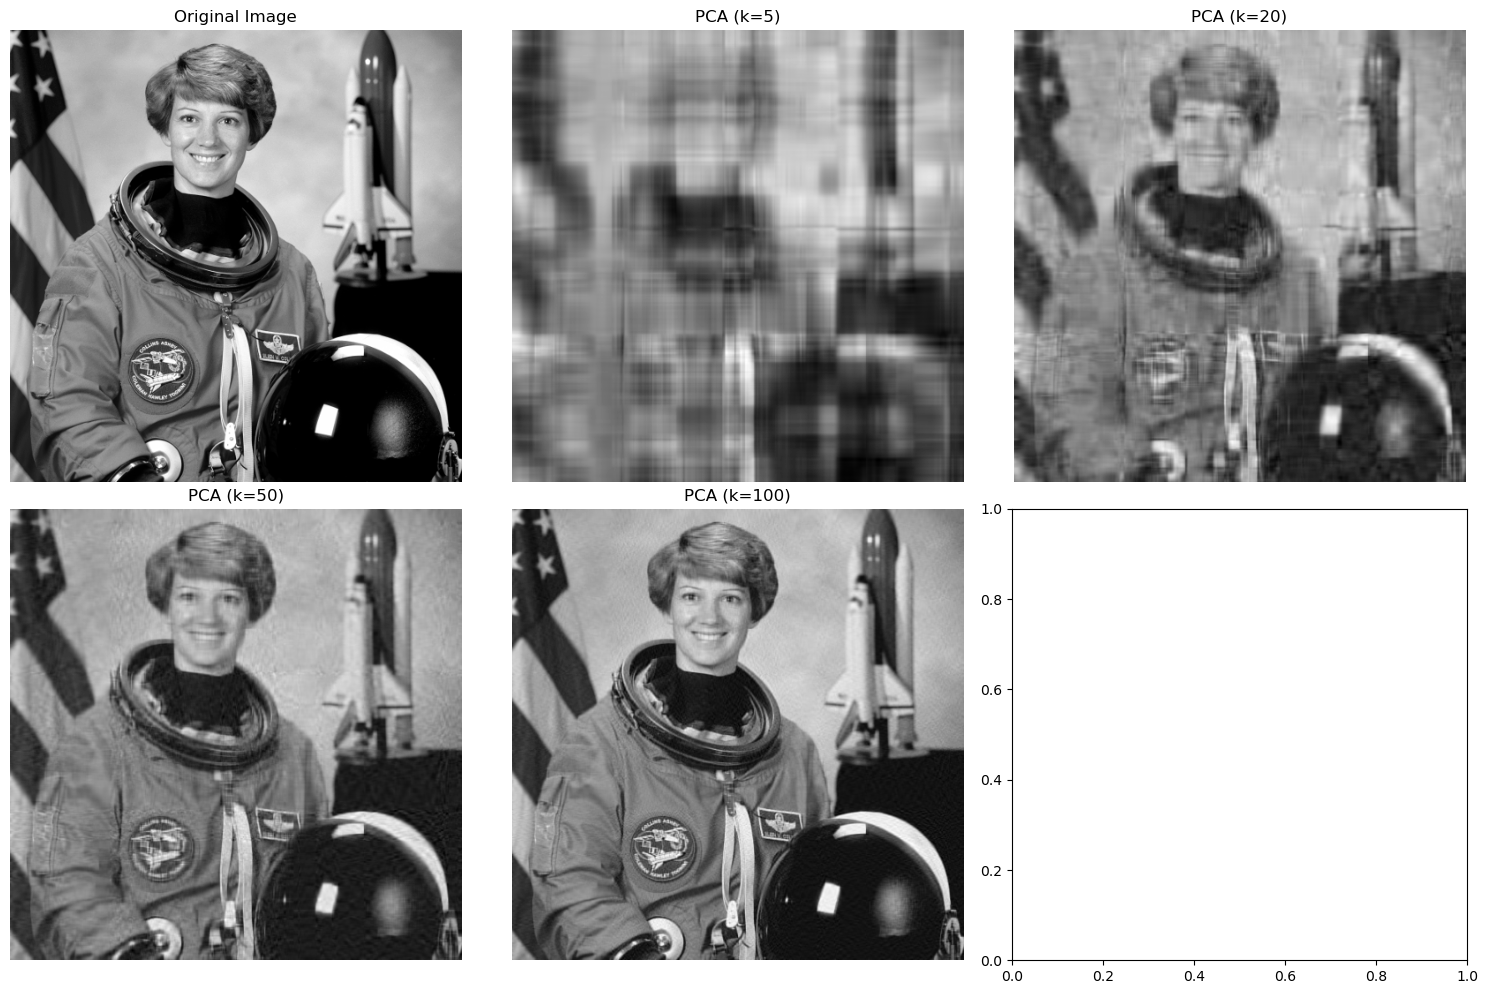

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

axes[0].imshow(X, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, k in enumerate(k_values):
    axes[i+1].imshow(reconstructed_images['PCA'][k], cmap='gray')
    axes[i+1].set_title(f'PCA (k={k})')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# Implementing Truncated SVD

In [13]:
for k in k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    
    X_svd = svd.fit_transform(X)
    
    X_reconstructed = svd.inverse_transform(X_svd)
    
    reconstructed_images['Truncated SVD'][k] = X_reconstructed
    
    mse = mean_squared_error(X, X_reconstructed)
    mse_values['Truncated SVD'].append(mse)
    
    print(f"  k={k}: MSE = {mse:.6f}")

  k=5: MSE = 0.024051
  k=20: MSE = 0.006135
  k=50: MSE = 0.001841
  k=100: MSE = 0.000515


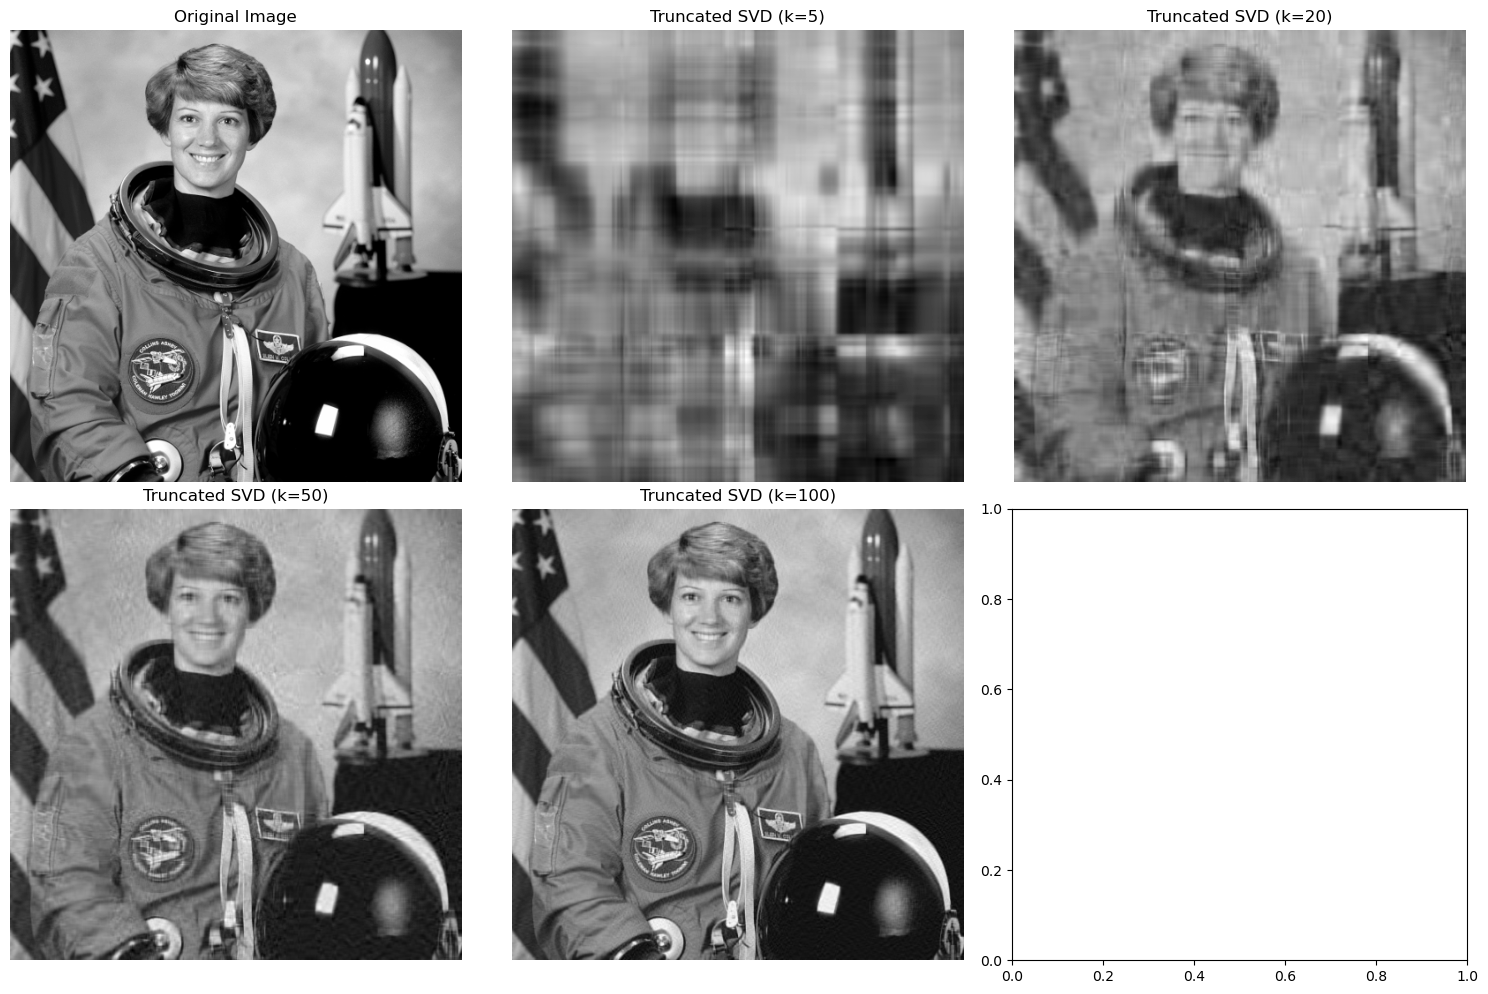

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

axes[0].imshow(X, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, k in enumerate(k_values):
    axes[i+1].imshow(reconstructed_images['Truncated SVD'][k], cmap='gray')
    axes[i+1].set_title(f'Truncated SVD (k={k})')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# Implementing Kernel PCA (With RBF Kernel)

In [15]:
print("Performing Kernel PCA (RBF) with different gamma values...")

gamma_values = [0.01, 0.1, 1.0, 10.0]
best_results = {}

for gamma in gamma_values:
    print(f"\nTrying gamma={gamma}")
    mse_list = []
    
    for k in k_values:
        try:
            kpca = KernelPCA(n_components=k, kernel='rbf', 
                           gamma=gamma,  
                           fit_inverse_transform=True, 
                           alpha=0.00005,  
                           random_state=42,
                           eigen_solver='auto',
                           max_iter=1000)  
            
            X_kpca = kpca.fit_transform(X)
            
            X_reconstructed = kpca.inverse_transform(X_kpca)
            
            mse = mean_squared_error(X, X_reconstructed)
            mse_list.append(mse)
            
            print(f"  k={k}: MSE = {mse:.6f}")

        except Exception as e:
            print(f"  k={k}: Error - {str(e)}")
            mse_list.append(np.nan)
    
    best_results[gamma] = mse_list

print("\nBest gamma selection based on MSE:")

for gamma, mse_list in best_results.items():
    avg_mse = np.nanmean(mse_list)
    print(f"gamma={gamma}: Average MSE = {avg_mse:.6f}")

Performing Kernel PCA (RBF) with different gamma values...

Trying gamma=0.01
  k=5: MSE = 0.012429
  k=20: MSE = 0.003941
  k=50: MSE = 0.001683
  k=100: MSE = 0.000664

Trying gamma=0.1
  k=5: MSE = 0.023101
  k=20: MSE = 0.005138
  k=50: MSE = 0.000768
  k=100: MSE = 0.000191

Trying gamma=1.0
  k=5: MSE = 0.058846
  k=20: MSE = 0.041461
  k=50: MSE = 0.030248
  k=100: MSE = 0.010915

Trying gamma=10.0
  k=5: MSE = 0.074169
  k=20: MSE = 0.065924
  k=50: MSE = 0.055210
  k=100: MSE = 0.038184

Best gamma selection based on MSE:
gamma=0.01: Average MSE = 0.004679
gamma=0.1: Average MSE = 0.007299
gamma=1.0: Average MSE = 0.035368
gamma=10.0: Average MSE = 0.058372


In [16]:
gamma = 0.1
alpha = 0.00005
for k in k_values:
    try:
        kpca = KernelPCA(gamma=gamma, n_components=k, kernel='rbf', fit_inverse_transform=True, 
                         alpha=alpha, random_state=42)
       
        X_kpca = kpca.fit_transform(X)
        
        X_reconstructed = kpca.inverse_transform(X_kpca)
        
        reconstructed_images['Kernel PCA (RBF)'][k] = X_reconstructed
        
        mse = mean_squared_error(X, X_reconstructed)
        mse_values['Kernel PCA (RBF)'].append(mse)
        
        print(f"  k={k}: MSE = {mse:.6f}")
    except Exception as e:
        print(f"  k={k}: Error - {str(e)}")
        reconstructed_images['Kernel PCA (RBF)'][k] = np.zeros_like(X)
        mse_values['Kernel PCA (RBF)'].append(np.nan)

  k=5: MSE = 0.023101
  k=20: MSE = 0.005138
  k=50: MSE = 0.000768
  k=100: MSE = 0.000191


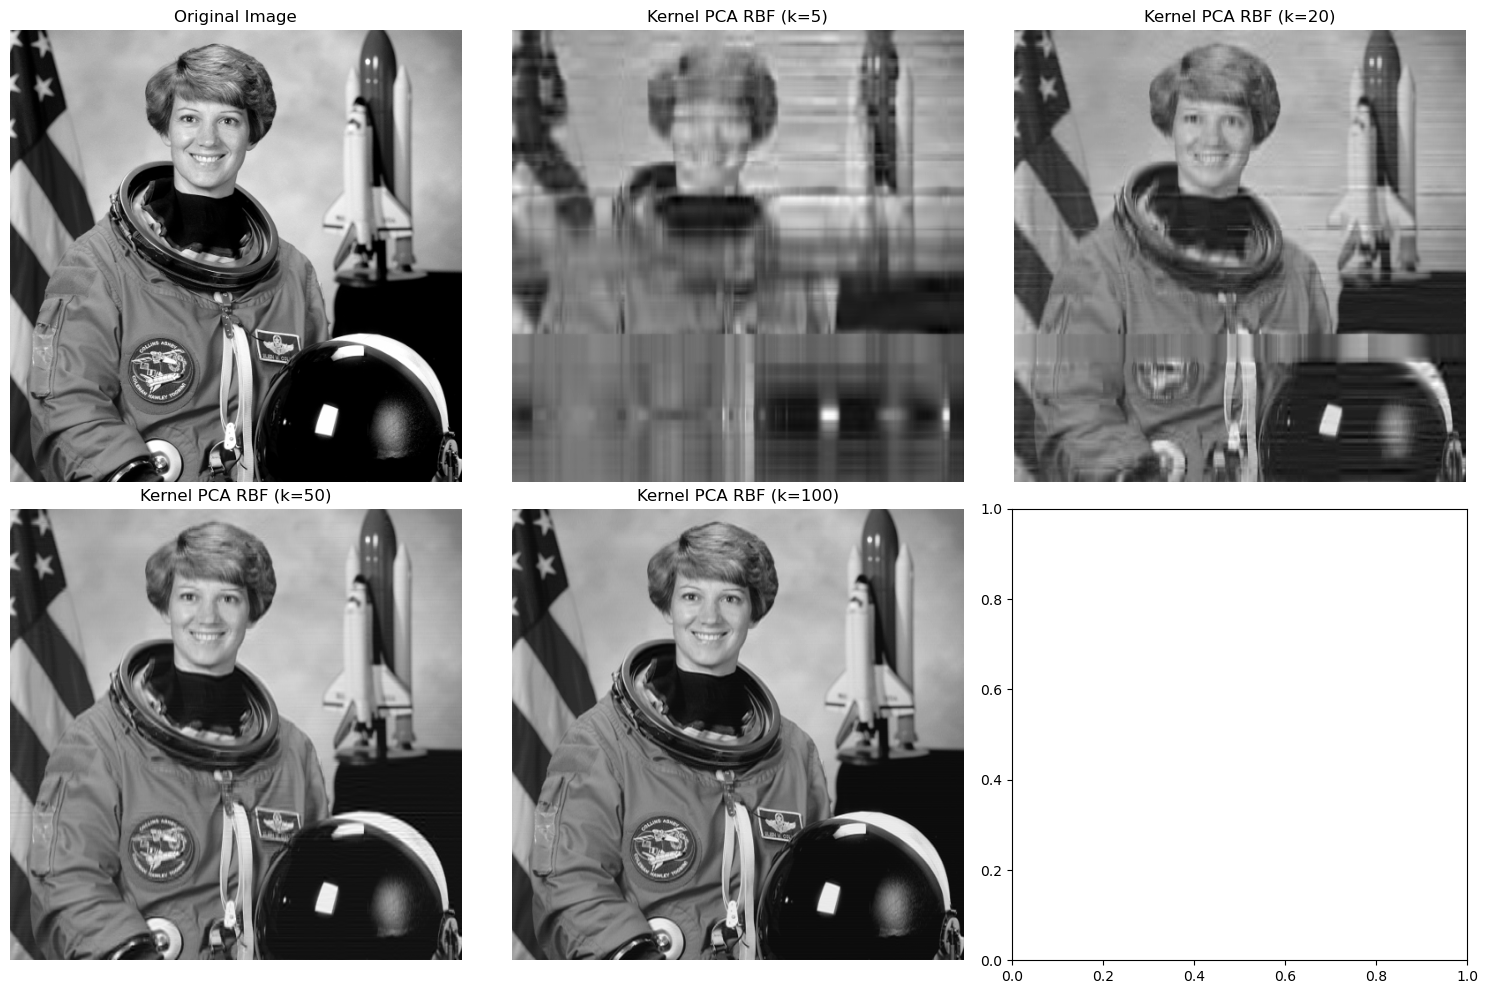

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

axes[0].imshow(X, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, k in enumerate(k_values):
    if k in reconstructed_images['Kernel PCA (RBF)']:
        axes[i+1].imshow(reconstructed_images['Kernel PCA (RBF)'][k], cmap='gray')
        axes[i+1].set_title(f'Kernel PCA RBF (k={k})')
        axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# Implementing NMF 

In [18]:
for k in k_values:
    try:
        nmf = NMF(n_components=k, init='random', random_state=42, max_iter=500)
        
        W = nmf.fit_transform(X)
        
        H = nmf.components_
        
        X_reconstructed = W @ H
        
        reconstructed_images['NMF'][k] = X_reconstructed
        
        mse = mean_squared_error(X, X_reconstructed)
        mse_values['NMF'].append(mse)
        
        print(f"  k={k}: MSE = {mse:.6f}")
    except Exception as e:
        print(f"  k={k}: Error - {str(e)}")
        reconstructed_images['NMF'][k] = np.zeros_like(X)
        mse_values['NMF'].append(np.nan)

  k=5: MSE = 0.025495
  k=20: MSE = 0.007944
  k=50: MSE = 0.003130
  k=100: MSE = 0.001202


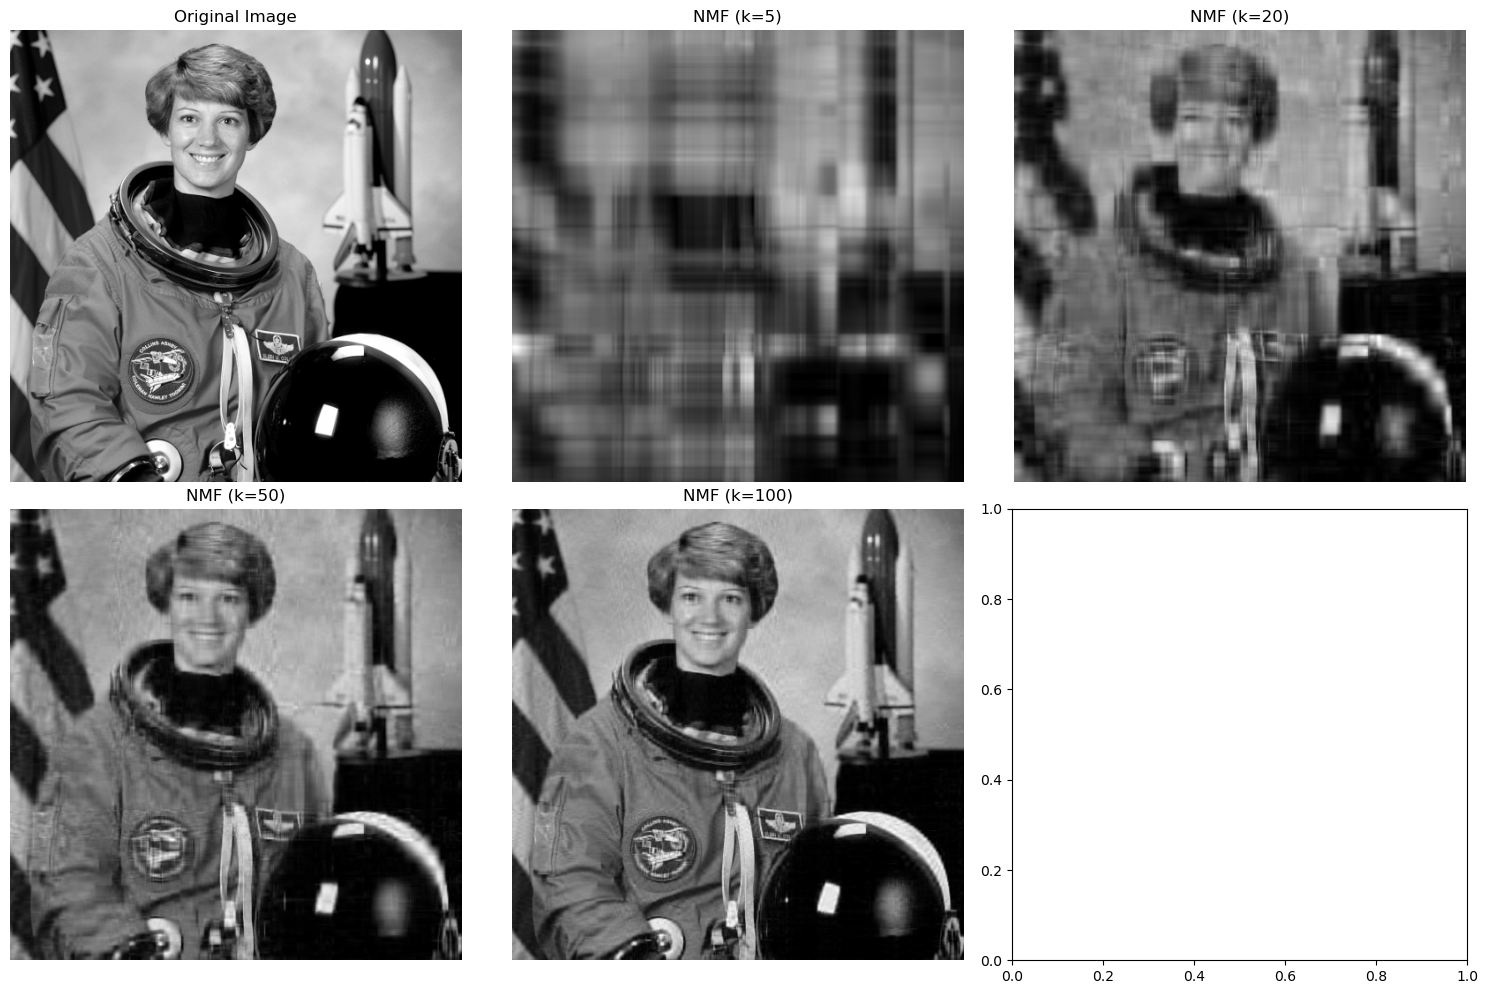

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

axes[0].imshow(X, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, k in enumerate(k_values):
    if k in reconstructed_images['NMF']:
        axes[i+1].imshow(reconstructed_images['NMF'][k], cmap='gray')
        axes[i+1].set_title(f'NMF (k={k})')
        axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# Reconstruction Quality Analysis

In [20]:
print("Comparison of MSE values for different methods and k values:")
print("\n" + "="*70)
print(f"{'Method':<20} | {'k=5':<12} | {'k=20':<12} | {'k=50':<12} | {'k=100':<12}")
print("="*70)

for method in mse_values:
    mse_str = ""
    for i, k in enumerate(k_values):
        if i < len(mse_values[method]):
            mse_val = mse_values[method][i]
            if np.isnan(mse_val):
                mse_str += f" | {'N/A':<12}"
            else:
                mse_str += f" | {mse_val:.6f}"
        else:
            mse_str += f" | {'N/A':<12}"
    print(f"{method:<20}{mse_str}")
print("="*70)

Comparison of MSE values for different methods and k values:

Method               | k=5          | k=20         | k=50         | k=100       
PCA                  | 0.021831 | 0.005913 | 0.001805 | 0.000509
Truncated SVD        | 0.024051 | 0.006135 | 0.001841 | 0.000515
Kernel PCA (RBF)     | 0.023101 | 0.005138 | 0.000768 | 0.000191
NMF                  | 0.025495 | 0.007944 | 0.003130 | 0.001202


# MSE Comparison

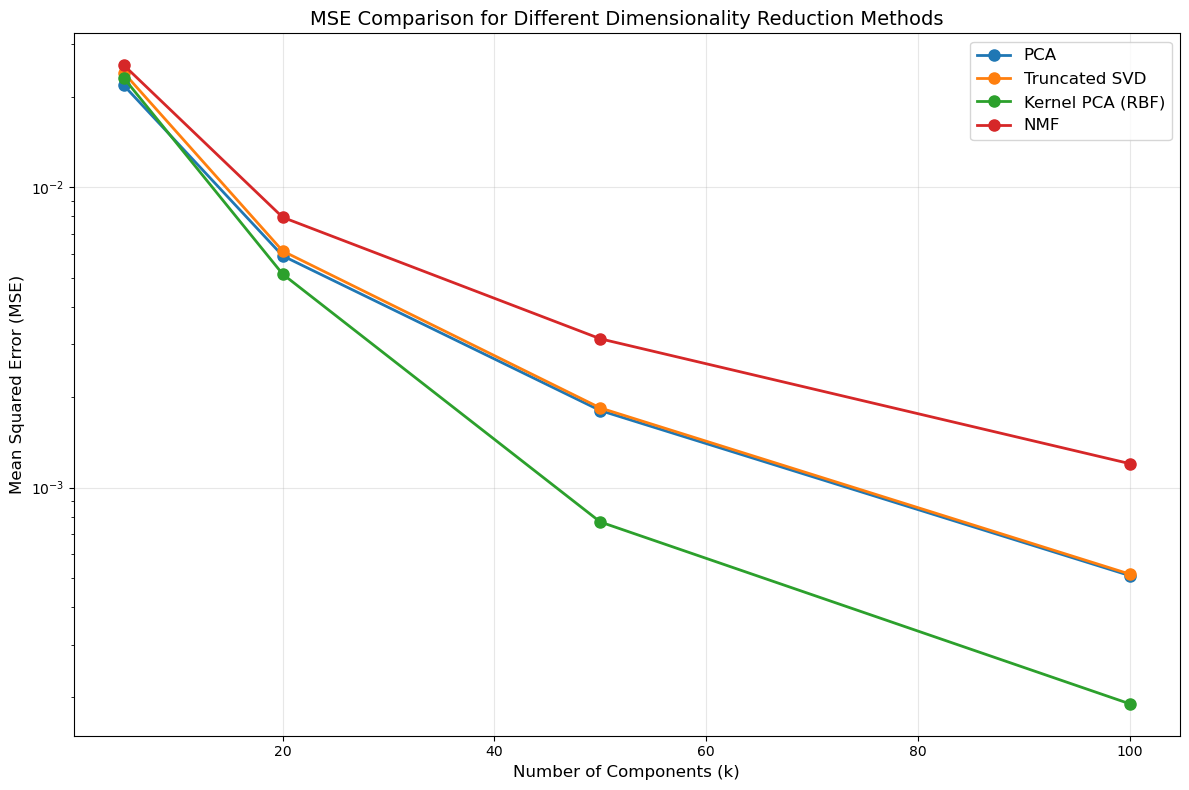

In [21]:
plt.figure(figsize=(12, 8))

for method in mse_values:
    if method == 'Kernel PCA (RBF)':
        valid_indices = [i for i, val in enumerate(mse_values[method]) if not np.isnan(val)]
        valid_k = [k_values[i] for i in valid_indices]
        valid_mse = [mse_values[method][i] for i in valid_indices]
        plt.plot(valid_k, valid_mse, 'o-', linewidth=2, markersize=8, label=method)
    else:
        plt.plot(k_values, mse_values[method], 'o-', linewidth=2, markersize=8, label=method)

plt.xlabel('Number of Components (k)', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('MSE Comparison for Different Dimensionality Reduction Methods', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Comprehensive Visualization of All Reconstructions

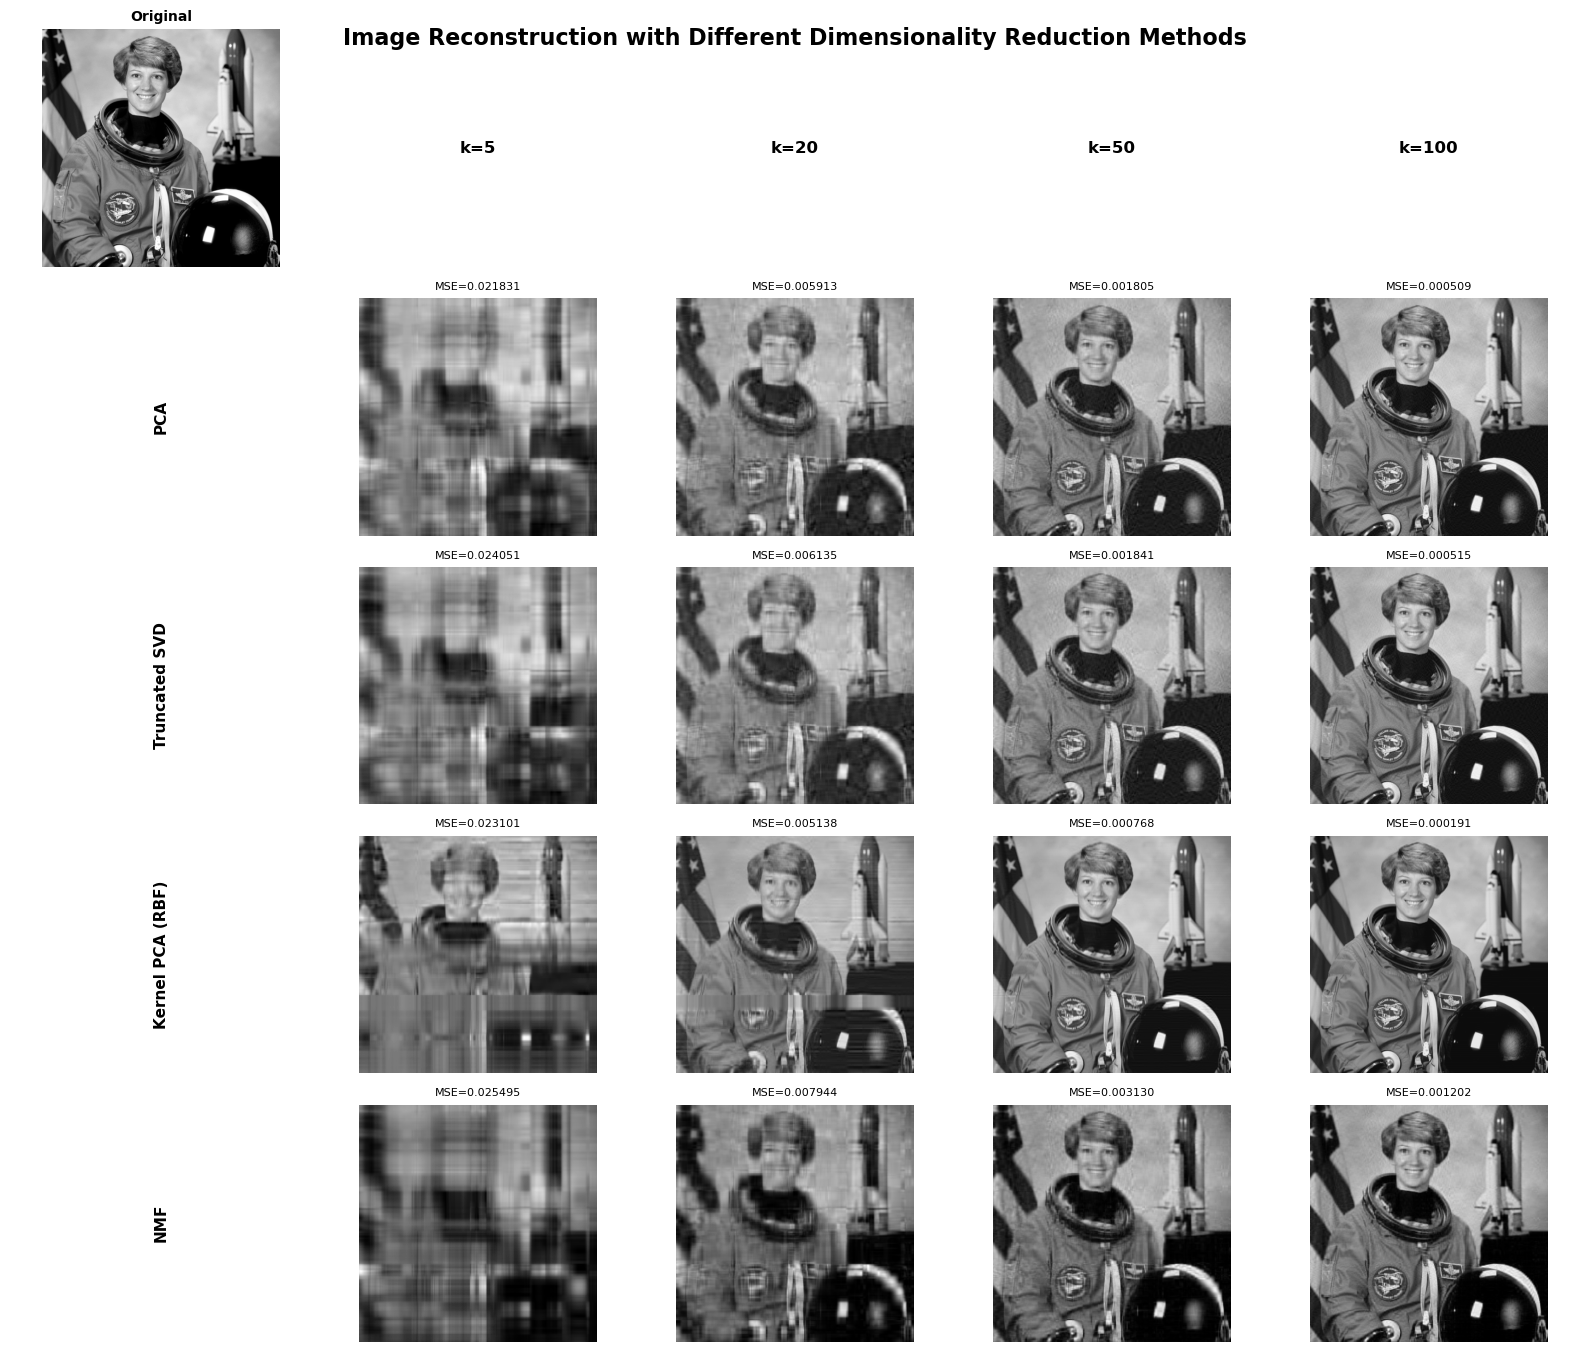

In [22]:
fig, axes = plt.subplots(len(mse_values) + 1, len(k_values) + 1, figsize=(16, 14))

axes[0, 0].imshow(X, cmap='gray')
axes[0, 0].set_title('Original', fontsize=10, fontweight='bold')
axes[0, 0].axis('off')

for j, k in enumerate(k_values):
    axes[0, j+1].text(0.5, 0.5, f'k={k}', ha='center', va='center', fontsize=12, fontweight='bold')
    axes[0, j+1].axis('off')

methods = list(mse_values.keys())
for i, method in enumerate(methods):
    axes[i+1, 0].text(0.5, 0.5, method, ha='center', va='center', 
                      fontsize=11, fontweight='bold', rotation=90)
    axes[i+1, 0].axis('off')

for i, method in enumerate(methods):
    for j, k in enumerate(k_values):
        if k in reconstructed_images[method]:
            img = reconstructed_images[method][k]
            axes[i+1, j+1].imshow(img, cmap='gray')
            
            if i < len(mse_values[method]) and j < len(mse_values[method]):
                mse_val = mse_values[method][j]
                if not np.isnan(mse_val):
                    axes[i+1, j+1].set_title(f'MSE={mse_val:.6f}', fontsize=8)
        
        axes[i+1, j+1].axis('off')

plt.suptitle('Image Reconstruction with Different Dimensionality Reduction Methods', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()